# <center> CLASSIFICAÇÃO DE GRANITOS

In [1]:
#utilitários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Pré processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#Modelos
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


#Avaliadores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, confusion_matrix
from sklearn.utils import compute_sample_weight

#Otimizadores
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#salvar e carregar modelos treinados
import joblib

#filtrando alertas
import warnings
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)

#parâmetros para o matplotlib
plt.rcParams.update({'font.size': 14})

In [2]:
#funções usadas no notebook

def treino_de_classificadores(classificadores, X_treino, y_treino, pesos):
    for classificador in classificadores:
        classificador.fit(X_treino, np.ravel(y_treino), sample_weight=pesos)
        y_previsao = cross_val_predict(classificador, X_treino, y_treino, cv=10)
        precisao = precision_score(y_treino, y_previsao, average = 'macro')
        revocacao = recall_score(y_treino, y_previsao, average = 'macro')
        pontuacao_f1 = f1_score(y_treino, y_previsao, average = 'macro')
        print(classificador.__class__.__name__)
        print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}')
        
def teste_de_modelos(modelos, X_teste, y_teste):
    for modelo in modelos:
        previsoes_teste = modelo.predict(X_teste)
        print(modelo.__class__.__name__)
        print(classification_report(y_teste, previsoes_teste))
        print('_________________________________________________________________________________________________________')
        
def metricas_score(modelos, X_teste, y_teste):
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao, average='macro')
        precisao = precision_score(y_teste, previsao, average='macro')
        acuracia = accuracy_score(y_teste, previsao)
        metricas_modelo[indice] = nome, f1, acuracia, precisao
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão'])

## <center> CARREGANDO OS DADOS

In [3]:
#Carregando o database tratado
database = pd.read_csv('dataset/granitos_db_att.csv', sep = '\t', index_col = 0)
database.head()

,SiO2,TiO2,Al2O3,FeOt,CaO,MgO,MnO,K2O,Na2O,A/NK,A/CNK,Fe#,K2O/Na2O,Na2O+K2O,Q,An,Ab,Or,Group
0,65.40690,0.827037,17.08490,4.914410,1.813515,1.796028,0.077149,5.131949,2.660096,1.719984,1.291329,0.732353,1.929235,7.792045,24.548928,7.115483,22.508991,30.328349,1- CPG & MPG
1,69.64232,0.708766,14.88713,4.186309,1.436880,1.629346,0.053972,5.018386,2.215911,1.639651,1.273279,0.719834,2.264706,7.234297,32.669551,5.684928,18.750421,29.657224,1- CPG & MPG
2,70.61077,0.570585,15.28393,2.822104,1.204323,1.330627,0.053181,5.597277,2.329983,1.544776,1.264847,0.679578,2.402282,7.927260,31.635693,4.686449,19.715667,33.078304,1- CPG & MPG
3,70.61724,0.477503,15.70859,2.508109,1.311569,0.977942,0.040661,5.280680,2.877528,1.502937,1.223734,0.719470,1.835145,8.158208,29.973384,5.199155,24.348840,31.207307,1- CPG & MPG
4,70.70878,0.532211,15.28031,2.535746,1.235924,1.207156,0.060856,5.569955,2.642243,1.472364,1.210301,0.677481,2.108040,8.212198,30.221927,4.649750,22.357924,32.916839,1- CPG & MPG


### <center> PRE PROCESSAMENTO

In [4]:
#verificando dados ausentes no database

database.isna().sum()

SiO2        0
TiO2        0
Al2O3       0
FeOt        0
CaO         0
MgO         0
MnO         0
K2O         0
Na2O        0
A/NK        0
A/CNK       0
Fe#         0
K2O/Na2O    0
Na2O+K2O    0
Q           0
An          0
Ab          0
Or          0
Group       0
dtype: int64

In [5]:
#Removendo colunas com dados ausentes

database = database.dropna(subset=['MnO', 'TiO2','FeOt', 'MgO', 'Na2O', 'CaO', 'Al2O3'])


#Separando variáveis preditoras e variável alvo

database_preditores = database[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']]

database_alvo = database[['Group']]

In [6]:
#Escalonando as variáveis numéricas

atributos_numericos = ['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']

tratamento_pipeline = ColumnTransformer([
    ("atributos_numéricos", StandardScaler(), atributos_numericos),
])

database_preditores = pd.DataFrame(tratamento_pipeline.fit_transform(database_preditores))

In [7]:
#Preparando a separação dos dados de treino e teste


#Realizando um amostragem estratificada
X_treino, X_teste, y_treino, y_teste = train_test_split(database_preditores, database_alvo, test_size=0.30, stratify=database_alvo, random_state=42)

In [8]:
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((2230, 9), (956, 9), (2230, 1), (956, 1))

# <center> TESTANDO OS MELHORES MODELOS

In [9]:
#Melhores modelos pós grid search (omiti o grid search aqui devido ao grande tempo de execução)

best_rnd_clf = RandomForestClassifier(bootstrap=False, max_features=3, criterion='entropy', n_estimators=100, random_state=42)
best_svc_clf = SVC(kernel='rbf' ,C=300, gamma=1, random_state=42)
xgb_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.2, max_delta_step=0,
               max_depth=6, min_child_weight=1,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=5, objective='multi:softprob', predictor='auto',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5,
               subsample=0.9, tree_method='exact', validate_parameters=1,
               verbosity=None)

xgb_RF = xgb.XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.2, max_delta_step=0,
               max_depth=9, min_child_weight=1,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=100, objective='multi:softprob', predictor='auto',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5,
               subsample=0.9, tree_method='exact', validate_parameters=1,
               verbosity=None)

modelos = [best_rnd_clf, best_svc_clf, xgb_best, xgb_RF]

In [10]:
#Treinando classificadores com pesos para as classes
pesos = compute_sample_weight("balanced", y_treino)
treino_de_classificadores(modelos, X_treino, y_treino, pesos);

RandomForestClassifier
precisão:0.8711052671023637, revocação:0.8669905626534034, F1 score: 0.8688077693908555
SVC
precisão:0.857752911494461, revocação:0.8291700238020058, F1 score: 0.8410048396093179
XGBClassifier
precisão:0.8776334847380808, revocação:0.86763373986093, F1 score: 0.8723133820723662
XGBRFClassifier
precisão:0.8498942488853564, revocação:0.8407798079757326, F1 score: 0.84459454832353


In [11]:
metricas_modelos = metricas_score(modelos, X_teste, y_teste)

In [12]:
metricas_modelos

,Modelo,F1,Acurácia,Precisão
0,RandomForestClassifier,0.880107,0.869247,0.878013
1,SVC,0.860072,0.855649,0.880950
2,XGBClassifier,0.871072,0.860879,0.870260
3,XGBRFClassifier,0.821405,0.801255,0.810362


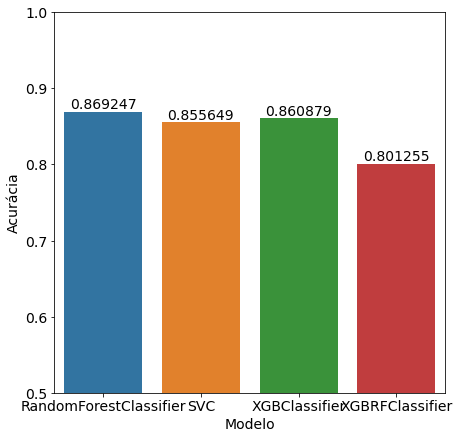

In [13]:
plt.figure(figsize = (7, 7))
plt.ylim(0.5, 1)
ax = sns.barplot(x=metricas_modelos['Modelo'], y=metricas_modelos['Acurácia'], data=metricas_modelos)
for container in ax.containers:
    ax.bar_label(container)
#plt.savefig('Scores_modelos.pdf', dpi=600, format='pdf')